# Simulation experiments with IPSS

In [23]:
%pip install -q ipss

from ipss import ipss
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import urllib.request

# Download and import the RNA-seq ovarian cancer data
url = 'https://drive.google.com/uc?export=download&id=1wK3G5B6gGtYvozhYaaKeIAZQ7g4p82em'
urllib.request.urlretrieve(url, 'ovarian_rnaseq.npy')

('ovarian_rnaseq.npy', <http.client.HTTPMessage at 0x7d2d8fd719c0>)

## Helper functions for generating data

In [24]:
# function for generating features
def generate_features(n, p, feature_type='standard_normal', rho=None, standardize=True):
	if feature_type == 'standard_normal':
		X = np.random.normal(0, 1, size=(n,p))
	elif feature_type == 'toeplitz':
		if rho is None or not (0 < rho < 1):
			raise ValueError("A rho between 0 and 1 must be specified for the Toeplitz feature type.")
		Sigma = np.empty((p,p))
		for i in range(p):
			for j in range(p):
				Sigma[i,j] = rho**np.abs(i-j)
		X = np.random.multivariate_normal(np.zeros(p), Sigma, size=n)
	elif feature_type == 'ovarian_rnaseq':
		X_full = np.load('ovarian_rnaseq.npy')
		n_full, p_full = X_full.shape
		samples = np.random.choice(n_full, size=n, replace=False)
		features = np.random.choice(p_full, size=p, replace=False)
		X = X_full[:,features]
		X = X[samples,:]
	else:
		raise ValueError(f"Unknown feature_type: {feature_type}")

	if standardize:
		X = StandardScaler().fit_transform(X)
	return X

# function for generating response
def generate_response(X, n_true, snr, nonlinear=False, response_type='continuous'):

	# dimensions
	n, p = X.shape

	# randomly select true features
	true_features = np.random.choice(p, n_true, replace=False)

	# signal
	if nonlinear:

		function_list = [
			lambda x, alpha, beta: (1 + np.tanh((alpha/2) * (x - beta))) / 2,
			lambda x, alpha, beta: np.exp(-alpha * x**2),
		]
		alpha_range = [1, 3]
		beta_range = [-1, 1]
		n_func = len(function_list)

		# generate partitions
		n_partitions = np.random.choice(np.arange(int(n_true / 2), n_true + 1))
		array = np.arange(n_true)
		np.random.shuffle(array)
		split_points = np.sort(np.random.choice(range(1, n_true), n_partitions - 1, replace=False))
		partitions = np.split(array, split_points)
		partitions = [part.tolist() for part in partitions]

		# apply functions to partitioned features
		signal = np.zeros(n)
		sums = np.zeros((n, n_partitions))
		for i, partition in enumerate(partitions):
			for j in partition:
				sums[:,i] += X[:,true_features[j]]
			sums[:,i] -= np.mean(sums[:,i])
			sums[:,i] /= np.std(sums[:,i])
			sums[:,i] *= np.random.choice([-1,1])
			f = function_list[np.random.choice(n_func)]
			alpha = np.random.uniform(alpha_range[0], alpha_range[1])
			beta = np.random.uniform(beta_range[0], beta_range[1])
			signal += np.random.choice([-1,1]) * f(sums[:,i], alpha, beta)
	else:
		beta = np.zeros(p)
		beta[true_features] = np.random.normal(0, 1, size=n_true)
		signal = X @ beta


	# add noise to signal to get response
	if response_type == 'continuous':
		sigma = np.sqrt(np.var(signal) / snr)
		y = signal + np.random.normal(0, sigma, size=n)
		y -= np.mean(y)
		y /= np.std(y)
	else:
		signal -= np.mean(signal)
		prob = 1 / (1 + np.exp(-snr * signal))
		y = np.random.binomial(1, prob, size=n)

	return y, true_features

## Generate data
#### Options for feature_type are
- 'standard_normal' for features from standard normal distribution
- 'toeplitz' for features from Toeplitz model with correlation parameter 0 <= rho <= 1 (larger rho = more correlation)
- 'ovarian_rnaseq' for features from real RNA-seq data from ovarian cancer patients (The Cancer Genome Atlas)

In [25]:
# set random seed
np.random.seed(302)

# simulation parameters
n = 500 # number of samples
p = 500 # number of features
n_true = 20 # number of true features
snr = 2 # signal-to-noise ratio
nonlinear = True # nonlinear relationship between features and response if True, linear if False
response_type = 'continuous' # 'binary' for classification or 'continuous' for regression

# generate features
X = generate_features(n, p, feature_type='ovarian_rnaseq', rho=0.5)

# generate response and true features
y, true_features = generate_response(X, n_true, snr, nonlinear=nonlinear, response_type=response_type)

## Run IPSS

In [26]:
ipss_result = ipss(X, y)

## Analyze results
Note: This is just one simulation; actual E(FP) and FDR performance is best seen by averaging over repeated simulations.

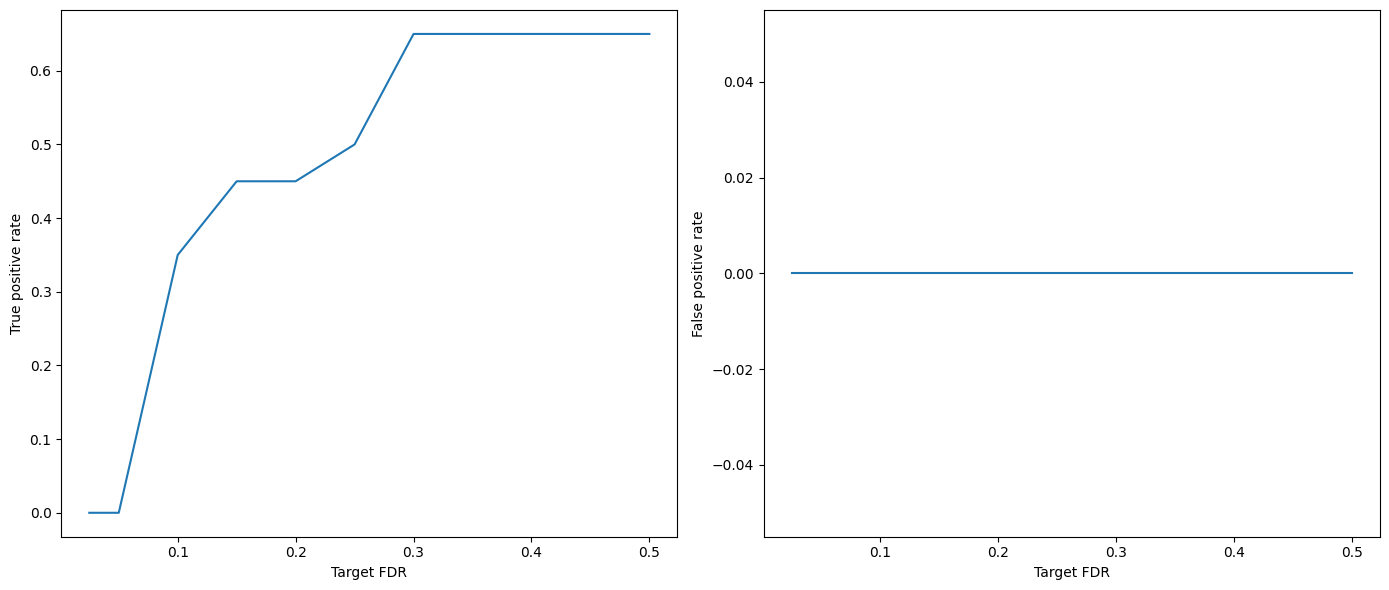

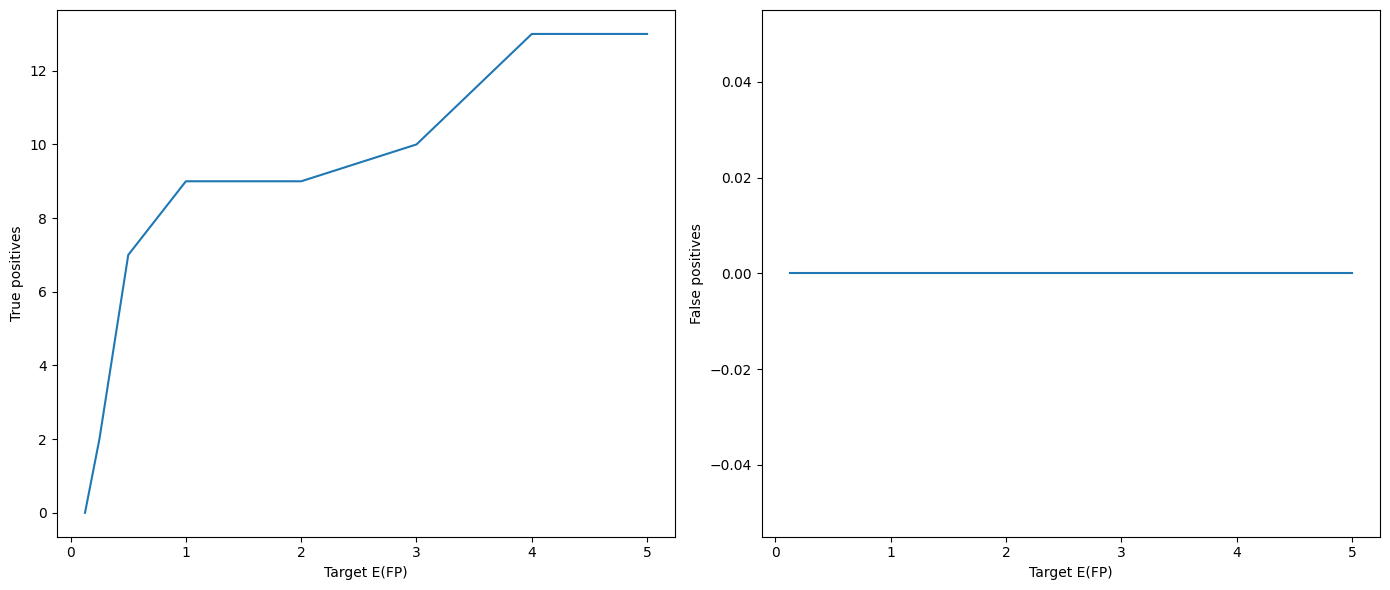

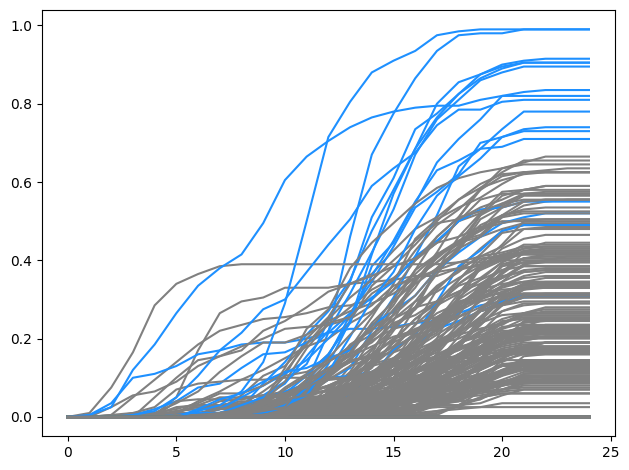

In [27]:
plot_target_fdr = True
plot_target_efp = True
plot_stability_paths = True

if plot_target_fdr:
	target_fdrs = [0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.45, 0.5]
	q_values = ipss_result['q_values']
	tprs, fdrs = np.zeros_like(target_fdrs), np.zeros_like(target_fdrs)
	for i, target_fdr in enumerate(target_fdrs):
		selected_features = [feature for (feature, q_value) in q_values if q_value <= target_fdr]
		tp, fp = 0, 0
		for feature in selected_features:
			if feature in true_features:
				tp += 1
			else:
				fp += 1
		tprs[i] = tp / n_true
		fdrs[i] = 0 if tp + fp == 0 else fp / (tp + fp)

	fig, ax = plt.subplots(1, 2, figsize=(14,6))
	ax[0].plot(target_fdrs, tprs)
	ax[1].plot(target_fdrs, fdrs)

	ax[0].set_xlabel(f'Target FDR')
	ax[1].set_xlabel(f'Target FDR')

	ax[0].set_ylabel(f'True positive rate')
	ax[1].set_ylabel(f'False positive rate')

	plt.tight_layout()
	plt.show()

if plot_target_efp:
	target_efps = [1/8, 1/4, 1/2, 1, 2, 3, 4, 5]
	efp_scores = ipss_result['efp_scores']
	tps, fps = np.zeros_like(target_efps), np.zeros_like(target_efps)
	for i, target_efp in enumerate(target_efps):
		selected_features = [feature for (feature, efp_score) in efp_scores if efp_score <= target_efp]
		for feature in selected_features:
			if feature in true_features:
				tps[i] += 1
			else:
				fps[i] += 1
	fig, ax = plt.subplots(1, 2, figsize=(14,6))
	ax[0].plot(target_efps, tps)
	ax[1].plot(target_efps, fps)

	ax[0].set_xlabel(f'Target E(FP)')
	ax[1].set_xlabel(f'Target E(FP)')

	ax[0].set_ylabel(f'True positives')
	ax[1].set_ylabel(f'False positives')

	plt.tight_layout()
	plt.show()

if plot_stability_paths:
	stability_paths = ipss_result['stability_paths']
	n_alphas, p = stability_paths.shape

	# blue paths for true features, gray for false features
	color = ['dodgerblue' if i in true_features else 'gray' for i in range(p)]

	for j in range(p):
		plt.plot(np.arange(n_alphas), stability_paths[:,j], color=color[j])
	plt.tight_layout()
	plt.show()